OLD!

# Trap Depth Calculation

Mark Brown  
Notebook Base Version 1.4

In [5]:
#YearMonthDay
date = "170617"

## Goals

This notebook is roughly based on the data notebook from 160908.

# General Setup

## Imports and Settings

### Miscellaneous Imports

In [6]:
import numpy as np
from numpy import array as arr
import pandas as pd
import collections
import math as m
from mpl_toolkits.mplot3d import axes3d
from astropy.io import fits

### Scipy

In [7]:
import scipy
from scipy.optimize import curve_fit as fit
import scipy.special as special

### Matplotlib Settings

In [8]:
import matplotlib as mpl
from matplotlib.pyplot import *
### set matplotlib plot defaults :D
%matplotlib inline
# Style controls many default colors in matplotlib plots.
# Change the following if you don't like dark backgrounds. Many other options.
style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = '#0a0a0a'
# the default cycling of colors in this mode isn't very good.
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['r','c','g','#FFFFFF','y','m','b'])
mpl.rcParams['figure.figsize'] = (18.0, 8.0)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['axes.formatter.limits'] = (0,1)
# jet is awful.
mpl.rcParams['image.cmap'] = 'inferno'
# to see all available options, decomment this line.
# print(mpl.rcParams)
mpl.rcParams['font.size'] = 14

### SymPy

In [9]:
import sympy as sp
sp.init_printing(use_latex=True)
# see the constants section for some constants set in sympy

### Javascript Settings

In [10]:
    %%javascript
    // the above line makes this entire cell run javascript commands.
    // this gets rid of scroll bars on the output by default. It's in javascript because javascript is used 
    // by Jupyter to actually render the notebook display.
    IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Constants

### Physics & Math Constants

In [278]:
# all in mks
# planck's constant
h = 6.6260700e-34
# reduced planck's constant
hbar = 1.0545718e-34
# boltzman's constant
k_B = 1.3806488e-23;
# speed of light (exact)
c = 299792458
# Stephan-Boltzman constant
sigma = 5.6704e-8
# atomic mass unit
amu = 1.6605390e-27
# rubidium 87 mass
Rb87_M = 86.909180527 * amu
# use numpy
pi = np.pi
# gravity constant
g = 9.80665

# linewidths
Rb87_D1Gamma = 36.1e6
Rb87_D2Gamma = 38.11e6

Rb87_AvgGamma = (Rb87_D1Gamma + Rb87_D2Gamma)/2

Rb87_I_Sat = 3.576
### should refine... for rubidium 87
# in m
Rb87_D2LineWavelength = 780e-9
# in Hz (1/s)
Rb87_D2LineFrequency = 377.1e12
# etc.
Rb87_D1LineWavelength = 795e-9
Rb87_D1LineFrequency = 384.2e12

### Lab Constants

In [12]:
andorDataRepository = "\\\\andor\\share\\Data and documents\\Data repository\\"
rawDataLoc = date + "\\Raw Data\\"

opBeamDacToVoltageConversionConstants = [8.5, -22.532, -1.9323, -0.35142]
# 7.4 x 7.4 micron mixel size
baslerScoutCcdPixelSize = 7.4e-6
# baslerAceCMosPixelSize = ???
# 16 micron pixels
andorPixelSize = 16e-6

dataRayPixelSize = 4.4e-6

### basler conversion... joules incident per greyscale count.
# number from theory of camera operation
cameraConversion = 117*10**-18 
# number from measurement. I suspect this is a little high because I think I underestimated the attenuation 
# of the signal by the 780nm filter.
# C = 161*10**-18 

# note: I don't know what the limiting aperture is, but I believe that it's a bit larger than either of these. 
# This parameter could probably be extracted from zeemax calculations.
# (in meters)
sillLensInputApertureDiameter = 40e-3
sillLensExitApertureDiameter = 40e-3

# need to look these up.
# tweezerBeamGaussianWaist = 4
# probeBeamGaussianWaist = ???

### Lab Volatile Constants

Constants that can easily change day to day depending on drifts, etc.

In [13]:
# Calibration of length (in meters) that atoms in the cell move vs pixels that the atoms move.
# this changes when the imaging system for the basler changes. there's a notebook for calculating this. 
baslerMetersPer4x4Pixel = 61.7818944758e-6
baslerMetersPerPixel = baslerMetersPer4x4Pixel / 4

### TODO: normalize these units to my standard units...

# in mW
sidemotPower = 0.75
# in mW
diagonalMPower = 9.3
# in cm
motRadius = 5 * baslerMetersPer4x4Pixel * 100
# in hertz
imagingDetuning = 10*10**6

baslerRawGain = 260

# in cm
axialImagingLensDiameter = 2.54
# in cm
axialImagingLensFocalLength = 10

# these obviously focus when we change iris diameters.
tweezerBeamApertureDiameter = 1.2*25.4e-3
probeBeamApertureDiameter = 25.4e-3

In [14]:
# Calibration of length (in meters) that atoms in the cell move vs pixels that the atoms move.
# this changes when the imaging system for the basler changes. there's a notebook for calculating this. 
baslerMetersPer4x4Pixel = 61.7818944758e-6
baslerMetersPerPixel = baslerMetersPer4x4Pixel / 4

### TODO: normalize these units to my standard units...

# in mW
sidemotPower = 0.75
# in mW
diagonalMPower = 9.3
# in cm
motRadius = 5 * baslerMetersPer4x4Pixel * 100
# in hertz
imagingDetuning = 10*10**6

baslerRawGain = 260

# in cm
axialImagingLensDiameter = 2.54
# in cm
axialImagingLensFocalLength = 10

### Sympy Constants

In [15]:
# Pauli Matrices
X = sigma_x = sp.Matrix([[0,1],[1,0]])
Y = sigma_y = sp.Matrix([[0,-1j],[1j,0]])
Z = sigma_z = sp.Matrix([[1,0],[0,-1]])
# Hadamard
H = hadamard = sp.Matrix([[1,1],[1,-1]])
# Phase Gate
S = phaseGate = sp.Matrix([[1,0],[0,1j]])
# Phase Shift gate
def phaseShiftGate(phi):
    return sp.Matrix([[1,0],[[0,sp.exp(1j*phi)]]])


## Functions

### Random Useful Functions

In [16]:
def what(obj, callingLocals=locals()):
    """
        quick function to print name of input and value. 
        If not for the default-Valued callingLocals, the function would always
        get the name as "obj", which is not what I want.    
    """
    name = "name not found"
    for k, v in list(callingLocals.items()):
         if v is obj:
            name = k
    print(name,"=", obj)

In [17]:
def round_sig(x, sig=3):
    return round(x, sig-int(m.floor(m.log10(abs(x)+np.finfo(float).eps)))-1)

### Generic functions for fits

In [18]:
def linear(x, a, b):
    return a * x + b
    
def quadraticDip(x,a,b,x0):
    # This assumes downward facing. Best to write another function for upward facing if need be, I think.
    if a < 0:
        return 10**10
    if b < 0:
        return 10**10
    return a + b*(x-x0)**2    
    
def quadraticBump(x,a,b,x0):
    # This assumes downward facing. Best to write another function for upward facing if need be, I think.
    if a < 0:
        return 10**10
    if b > 0:
        return 10**10
    return a + b*(x-x0)**2


def gaussian(x, A1, x01, sig1, offset):
    if (offset < 0):
        return 10**10
    return offset + A1 * np.exp(-(x-x01)**2/(2*sig1**2))


def doubleGaussian(x, A1, x01, sig1, A2, x02, sig2, offset):
    if (A1 < 0 or A2 < 0):
        # Penalize negative fits.
        return 10**10
    if (offset < 0):
        return 10**10
    return offset + A1 * np.exp(-(x-x01)**2/(2*sig1**2)) + A2 * np.exp(-(x-x02)**2/(2*sig2**2))

def tripleGaussian(x, A1, x01, sig1, A2, x02, sig2, A3, x03, sig3, offset ):
    if (A1 < 0 or A2 < 0 or A3 < 0):
        # Penalize negative fits.
        return 10**10
    if (offset < 0):
        return 10**10
    return (offset + A1 * np.exp(-(x-x01)**2/(2*sig1**2)) + A2 * np.exp(-(x-x02)**2/(2*sig2**2)) 
            + A3 * np.exp(-(x-x03)**2/(2*sig3**2)))

# Stolen from "http://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian
#-function-using-scipy-optimize-curve-fit-valueerror-and-m"
def gaussian_2D(coordinates, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    # limit the angle to a small range to prevent unncecessary flips of the axes. The 2D gaussian has two axes of symmetry,
    # so only a quarter of the 2pi is needed.
    if theta > pi/4 or theta < -pi/4:
        return 10e10
    x = coordinates[0]
    y = coordinates[1]
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def decayingCos(x, A, tau, f, phi, offset):
    # Just for sanity. Keep some numbers positive.
    if (A < 0):
        return x * 10**10
    if (phi < 0):
        return x * 10**10
    if (offset < 0):
        return x * 10**10
    # no growing fits.
    if (tau > 0):
        return x * 10**10
    return offset + (1 - A/2 * np.exp(-x/tau) * np.cos(2 * np.pi * f * x + phi))

def sincSquared(x, A, center, scale, offset):
    if (offset < 0):
        return x * 10**10
    if (A < 0):
        return x * 10**10
    return (A * np.sinc((x - center)/scale)**2 + offset)


def lorentzian(x, A, center, width, offset):
    if (offset < 0):
        return x * 10**10
    if (A < 0):
        return x * 10**10
    return (A /((x - center)**2 + (width/2)**2))


def poissonian(x, k, weight):    
    """
    This function calculates p_k{x} = weight * e^(-k) * k^x / x!.
    :param x: argument of the poissonian
    :param k: order or (approximate) mean of the poissonian.
    :param weight: a weight factor, related to the maximum data this is supposed to be fitted to, but typically over-
    weighted for the purposes of this function.
    :return: the poissonian evaluated at x given the parametes.
    """
    import numpy as np
    term = 1
    # calculate the term k^x / x!. Can't do this directly, x! is too large.
    for n in range(0, int(x)):
        term *= k / (x - n)
    return np.exp(-k) * term * weight

# Data Analysis Setup

This section can be safely removed if not doing data analysis, e.g. if just doing some other calculation or some numerical work or something.

## Miscellaneous Functions

### Random Useful Functions

In [19]:
def orderData(data, key):
    key, data = zip(*sorted(zip(key, data)))
    return arr(data), arr(key)

In [20]:
def getLabels(plotType):
    if plotType == "Detuning":
        xlabel = "Detuning (dac value)"
        title = "Detuning Scan"
    elif plotType == "Field":
        xlabel = "Differential Field Change / 2 (dac value)"
        title = "Differential Magnetic Field Scan"
    elif plotType == "Time(ms)":
        xlabel ="Time(ms)"
        title = "Time Scan"
    elif plotType == "Power":
        xlabel ="Power (dac units)"
        title = "Power Scan"
    else:
        xlabel = plotType
        title = ""
    return xlabel, title

In [21]:
def combineData(data, key):
    """
    combines similar key value data entries. data will be in order that unique key items appear in key. 
    For example, if key = [1,3,5,3,7,1], returned key and corresponding data will be newKey = [1, 3, 5, 7]
    """
    items = {}
    newKey = []
    newData = []
    for elem in key:
        #print(elem)
        if str(elem) not in items:
            indexes = [i for i, x in enumerate(key) if x == elem]
            # don't get it again
            items[str(elem)] = "!"
            newKey.append(elem)
            newItem = np.zeros((data.shape[1], data.shape[2]))
            # average together the corresponding data.
            for index in indexes:
                newItem += data[index]
            newItem /= len(indexes)
            newData.append(newItem)
    return arr(newData), arr(newKey)


### Loading Functions

In [22]:
def loadDataRay(num):
    fileName = andorDataRepository + rawDataLoc + "dataRay_" + str(num) + ".wct"
    file = pd.read_csv(fileName, header=None, skiprows=[0,1,2,3,4])
    data = file.as_matrix()
    for row in data:
        row[-1] = float(row[-1][:-2])
        for elem in row:
            elem = float(elem)
    return data.astype(float)

In [23]:
def loadBasler(num):
    path = andorDataRepository + rawDataLoc + "Run" + str(num) + ".txt"
    return pd.read_csv(path, sep='\t', header=None).as_matrix()

In [24]:
def loadCompoundBasler(num):
    path = andorDataRepository + rawDataLoc + "AceData_" + str(num) + ".txt"
    with open(path) as file:
        original=file.read()
        pics = original.split(";")
        dummy = os.linesep.join([s for s in pics[0].splitlines() if s]);
        dummy2 = dummy.split('\n')
        dummy2[0] = dummy2[0].replace(' \r','')
        data = np.zeros((len(pics), len(dummy2), len(arr(dummy2[0].split(' ')))))
        picInc = 0
        for pic in pics:
            # remove extra empty lines
            pic = os.linesep.join([s for s in pic.splitlines() if s])
            lines = pic.split('\n')
            lineInc = 0
            for line in lines:
                line = line.replace(' \r','')
                picLine = arr(line.split(' '))
                picLine = arr(list(filter(None, picLine)))
                data[picInc][lineInc] = picLine

                lineInc += 1
            picInc+=1
    return data

In [25]:
def loadFits(num):
    # Get the array from the fits file. That's all I care about.
    path = andorDataRepository + rawDataLoc + "data_" + str(num) + ".fits"
    with fits.open(path, "append") as fitsInfo:
        rawData = arr(fitsInfo[0].data);
    return rawData

In [26]:
def loadKey(num):
    key = np.array([]);
    path = andorDataRepository + rawDataLoc + "key_" + str(num) + ".txt"
    with open(path) as keyFile:
        for line in keyFile:
            key = np.append(key, float(line.strip('\n')))
        keyFile.close()            
    return key

### Specialty functions for fits

Coming from various theoretical calculations

In [27]:
def ballisticMotExpansion(t, sigma_y0, sigma_vy, sigma_I):
    """
    You can see a derivation of this in a different notebook for temperature calculations. I don't know why, but
    this function seems somewhat unstable as a fitting function. It doesn't always work very sensibly.
    """
    return sigma_I*np.sqrt((sigma_y0**2 + sigma_vy**2 * t**2)/(sigma_y0**2+sigma_vy**2*t**2+sigma_I**2))

def simpleMotExpansion(t, sigma_y0, sigma_vy):
    """
    For some reason calculations involving this tend to be wildly off... I need to look into this more the next time 
    I need to calculate a temperature.
    
    this simpler version ignores the size of the beam waist of the atoms. 
    It should generally behave better with noisy data.    
    """
    return sigma_y0 + sigma_vy * t

def beamWaistExpansion(z, w0, z0, wavelength):
    """ assuming gaussian intensity profile of I~exp{-2z^2/w{z}^2} """
    return w0 * np.sqrt(1+(wavelength*(z-z0)/(pi*w0**2))**2)

### Fitting Functions

Functions that take data as an input and implement some standardized techniques to guess parameters and
to try to fit the data.

In [28]:
def fitPic(picture, show=True, guessSigma_x=1, guessSigma_y=1):
    pos = np.unravel_index(np.argmax(picture), picture.shape)
    pic = picture.flatten()
    x = np.linspace(1, picture.shape[1], picture.shape[1])
    y = np.linspace(1, picture.shape[0], picture.shape[0])
    x, y = np.meshgrid(x, y)
    initial_guess = (np.max(pic) - np.min(pic),pos[1], pos[0],guessSigma_x,guessSigma_y,0,np.min(pic))
    try:        
        popt, pcov = fit(gaussian_2D, (x, y), pic, p0=initial_guess);
    except RuntimeError:
        popt = np.zeros(len(initial_guess))
        pcov = np.zeros((len(initial_guess), len(initial_guess)))
        raise RuntimeError('Fit Failed!')
    if show:
        data_fitted = gaussian_2D((x, y), *popt)
        fig, ax = subplots(1, 1)
        grid('off')
        im = ax.pcolormesh(picture, extent=(x.min(), x.max(), y.min(), y.max()))
        ax.contour(x, y, data_fitted.reshape(picture.shape[0],picture.shape[1]), 4, colors='w', alpha=0.2)
        fig.colorbar(im)
    return popt, np.sqrt(np.diag(pcov))


def fitPictures(pictures, dataRange, show=True):
    fitParameters = []
    fitErrors = []
    count = 0
    warningHasBeenThrown = False
    for picture in pictures:
        if count not in dataRange:
            count += 1
            fitParameters.append(np.zeros(7))
            fitErrors.append(np.zeros(7))
        try:
            parameters, errors = fitPic(picture, show=False)
        except RuntimeError:
            if not warningHasBeenThrown:
                print("Warning! Not all picture fits were able to fit the picture signal to a 2D Gaussian.\n"
                      "When the fit fails, the fit parameters are all set to zero.")
                warningHasBeenThrown = True
            parameters = np.zeros(7)
            errors = np.zeros(7)
        # append things regardless of whether the fit succeeds or not in order to keep things the right length.
        fitParameters.append(parameters)
        fitErrors.append(errors)
        count += 1
    return np.array(fitParameters), np.array(fitErrors)

In [29]:
def fitGaussianBeamWaist(data, key, wavelength):
    # expects waists as inputs
    initial_guess = [min(data.flatten()), key[int(3*len(key)/4)]]
    what(initial_guess)
    try:        
        # fix the wavelength
        # beamWaistExpansion(z, w0, wavelength)
        popt, pcov = fit(lambda x, a, b: beamWaistExpansion(x, a, b, wavelength), key, data, p0=initial_guess)
    except RuntimeError:
        popt = 0
        pcov = 0
        raise RuntimeError('Fit Failed!')
    return popt, pcov

## Data Analysis & Plotters

### Plotters

In [30]:
def plotPoints(key, majorPlot, minorPlot={}, circleLoc=(-1,-1), picture = arr([[]]), picTitle=""):
    """
    This plotter plots a scatter plot on the main axis from majorPlot,
    a scatter on the minor axis using minorPlot, and a picture using picture.
    
    Parameters:
    key: this is used for the x values of both the major plot and the minor plot.
    majorPlot: a dictionary with the following elements containing info for the main plot of the figure (REQUIRED):
        - "ax1": A dictionary containing info for plotting on the first axis (main axis) 
            with the following elements (REQUIRED):
            - "data": a 1 or 2-dimensional array with data to be plotted with key (REQUIRED)
            - "ylabel": label for axis 1 (on the left)
            - "legendLabels": an array with labels for each data set
        - "ax2": An optional dictionary containing info for plotting on the second axis, elements similar to ax1
        - "xlabel": label for the x axis
        - "title": title
        - "altKey": another key to plot on the other x-axis (above the plot).
    minorPlot: a dictionary with info for the minor plot. Same structure as majorPlotData, but optional.    
    """
    # Setup grid
    figure()
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)   
    # ### Main Plot
    fillPlotDataDefaults(majorPlot)
    majorAx1 = subplot(grid1[:, :11])
    colors = ['r','c','g','#FFFFFF','y','m','b']
    majorLineCount = 0
    lines = []
    if majorPlot['ax1']['data'].ndim == 1:
        lines += majorAx1.plot(key, majorPlot['ax1']['data'], 'o', label=majorPlot['ax1']['legendLabels'], 
                               color=colors[majorLineCount])
        majorLineCount += 1
    else:
        for data in majorPlot['ax1']['data']:
            lines += majorAx1.plot(key, data, 'o', label=majorPlot['ax1']['legendLabels'][majorLineCount], 
                                   color=colors[majorLineCount])
            majorLineCount += 1
    if 'fitYData' in majorPlot['ax1']:
        for fitCount in range(len(majorPlot['ax1']['fitYData'])):
            lines += majorAx1.plot(majorPlot['ax1']['fitXData'][fitCount], majorPlot['ax1']['fitYData'][fitCount], 
                                   label=majorPlot['ax1']['legendLabels'][majorLineCount], color=colors[fitCount])
            majorLineCount += 1
        
    majorAx1.set_ylabel(majorPlot['ax1']['ylabel'])
    majorAx1.grid(which='both', color='#FFFFFF')
    
    if 'ax2' in majorPlot:
        majorAx2 = majorAx1.twinx()
        if majorPlot['ax1']['data'].ndim == 1:
            lines += majorAx2.plot(key, majorPlot['ax2']['data'], 'o', label=majorPlot['ax2']['legendLabels'], 
                                   color=colors[majorLineCount])
            majorLineCount += 1
        else:
            count = 0
            for data in majorPlot['ax2']['data']:
                lines += majorAx2.plot(key, data, 'o', label=majorPlot['ax2']['legendLabels'][count],
                                       color=colors[majorLineCount])
                count += 1
                majorLineCount += 1
        majorAx2.set_ylabel(majorPlot['ax2']['ylabel'])
        majorAx2.spines['right'].set_color('m')
        majorAx2.spines['top'].set_color('m')
        majorAx2.yaxis.label.set_color('m')
        majorAx2.tick_params(axis='y', colors='m')
        #majorAx2.grid(color='m')
        majorAx2.grid(which='both', color='m')
        #majorAx2.set_yticklabels([round_sig(tick) for tick in arr(majorAx2.get_yticks().tolist())], rotation=70)
    
    majorAx1.legend(lines, [l.get_label() for l in lines], loc='best', fancybox=True, framealpha=0.4)
    majorAx1.set_xlabel(majorPlot['xlabel'])
    majorAx1.set_title(majorPlot['title'])

    #todo, maybe modify this if I want to use it in the future.
    if 'majorAltKey' in majorPlot:
        ax2 = majorAx1.twiny()
        ticks = majorAx1.get_xticks()
        ax2.plot(majorPlot['majorAltKey'], majorPlot['ax1']['data'], 'o')
        ax2.grid(color='c')
        ax2.spines['top'].set_color('c')
        ax2.xaxis.label.set_color('c')
        ax2.tick_params(axis='x', colors='c')
        ax2.set_xlabel("DAC Values")
        ax2.set_xlim(reversed(ax2.get_xlim()))
    
    # Minor Data Plot
    lines = []
    if 'ax1' in minorPlot:
        fillPlotDataDefaults(minorPlot)
        minorAx1 = subplot(grid1[0:6, 12:16])
        minorLineCount = 0
        if minorPlot['ax1']['data'].ndim == 1:
            lines += minorAx1.plot(key, minorPlot['ax1']['data'], 'o', label=minorPlot['ax1']['legendLabels'],
                                   color=colors[minorLineCount])
            minorLineCount += 1
        else:
            count = 0
            for data in minorPlot['ax1']['data']:
                lines += minorAx1.plot(key, data, 'o', label=minorPlot['ax1']['legendLabels'][count], 
                                       color=colors[minorLineCount])
                count += 1
                minorLineCount += 1
        minorAx1.set_ylabel(minorPlot['ax1']['ylabel'])
        
        if 'ax2' in minorPlot:
            minorAx2 = twinx(minorAx1)
            if minorPlot['ax1']['data'].ndim == 1:
                lines += minorAx2.plot(key, minorPlot['ax2']['data'], 'o', label=minorPlot['ax2']['legendLabels'],
                                       color=colors[minorLineCount])
                minorLineCount += 1
            else:
                count = 0
                for data in minorPlot['ax2']['data']:
                    lines += minorAx2.plot(key, data, 'o', label=minorPlot['ax2']['legendLabels'][count], 
                                           color=colors[minorLineCount], alpha=0.4)
                    count += 1
                    minorLineCount += 1
            minorAx2.set_ylabel(minorPlot['ax2']['ylabel'])
            minorAx2.spines['right'].set_color('m')
            minorAx2.spines['top'].set_color('m')
            minorAx2.yaxis.label.set_color('m')
            minorAx2.tick_params(axis='y', colors='m')
            minorAx2.grid(color='m')
        minorAx1.legend(lines, [l.get_label() for l in lines], loc='best', fancybox=True, framealpha=0.4)
        minorAx1.set_xlabel(minorPlot['xlabel'])
        minorAx1.set_title(minorPlot['title'])
        
    # Image
    if picture.size!=0:
        image = subplot(grid1[7:12, 12:16])
        im = image.pcolormesh(picture)
        image.grid(0)
        image.axis('off')
        image.set_title(picTitle)
        colorbar(im, ax=image)
        if (circleLoc!=(-1,-1)):
            circ = Circle(circleLoc, 0.2, color='r')
            image.add_artist(circ)

In [31]:
def plotHist(picture, data, xLabel="?", circLoc=(-1,-1), plotTitle='Histogram Data', binCount=100):
    # Setup grid
    grid1 = mpl.gridspec.GridSpec(12, 16)
    grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
    gridLeft = mpl.gridspec.GridSpec(12, 16)
    gridLeft.update(left=0.001, right=0.95, hspace=1000)
    gridRight = mpl.gridspec.GridSpec(12, 16)
    gridRight.update(left=0.2, right=0.946, wspace=0, hspace=1000)
    # ### Main Plot
    mainPlot = subplot(grid1[:, :12])
    # the bins should be of integer width, because poisson is an integer distribution
    mainPlot.hist(data, bins=binCount)
    mainPlot.set_xlabel(xLabel)
    mainPlot.set_ylabel('Occurances')
    title(plotTitle)
    image = subplot(grid1[6:12, 12:16])
    im = image.imshow(picture)
    image.grid(0)
    image.axis('off')
    colorbar(im, ax=image);
    if (circLoc!=(-1,-1)):
        circ = Circle(circLoc, 0.2, color='r')
        image.add_artist(circ)

### Crunchers

In [32]:
def integrateData(pictures):
    if len(pictures.shape) == 3:
        integratedData=np.zeros(pictures.shape[0])
        picNum=0
        for pic in pictures:
            for row in pic:
                for elem in row:
                    integratedData[picNum] += elem
            picNum+=1
    else:
        integratedData=0
        for row in pictures:
            for elem in row:
                integratedData += elem
    return integratedData

In [33]:
def processImageData(key, rawData, bg, window, xMin, xMax, yMin, yMax, accumulations, dataRange, zeroCorners):
    """
    Process the orignal data, giving back data that has been ordered and windowed as well as two other versions that 
    have either the background or the average of the pictures subtracted out.
    
    This is a helper function that is expected to be embedded in a package. As such, many parameters are simply 
    passed through some other function in order to reach this function, and all parameters are required.
    """
    # normalize for accumulations
    accumulationNormalizedData = rawData / accumulations
    # handle windowing defaults
    if window != (0,0,0,0):
        xMin = window[0]
        xMax = window[1]
        yMin = window[2]
        yMax = window[3]
    else:
        if xMax == 0:
            xMax = len(rawData[0])
        if yMax == 0:
            yMax = len(rawData[0][0])        
    # combine and order data.
    rawData, key = combineData(rawData, key)
    rawData, key = orderData(rawData, key)
    
    # window images.
    rawData = np.copy(arr(rawData[:,yMin:yMax, xMin:xMax]))
    # pull out the images to be used for analysis.
    if not dataRange == (0,0):
        rawData = rawData[dataRange[0]:dataRange[-1]]
        key = key[dataRange[0]:dataRange[-1]]
    
    # ### -Background Analysis
    # if user just entered a number, assume that it's a file number.
    if type(bg) == int and not bg == 0:
        bg = loadFits(bg)[0] / accumulations
    # window the background
    if not bg.size == 1:
        bg = np.copy(arr(bg[yMin:yMax, xMin:xMax]))
    dataMinusBg = np.copy(rawData)
    for pic in dataMinusBg:
        pic -= bg
    # ### -Average Analysis
    # make a picture which is an average of all pictures over the run.
    avgPic = 0;
    for pic in rawData:
        avgPic += pic
    avgPic /= len(rawData)
    
    dataMinusAvg = np.copy(rawData)
    for pic in dataMinusAvg:
        pic -= avgPic
    
    # it's important and consequential that the zeroing here is done after the background / corner is subtracted.
    if zeroCorners:
        for pic in dataMinusBg:
            cornerAvg = (pic[0,0] + pic[0,-1] + pic[-1, 0] + pic[-1,-1])/4     
            pic -= cornerAvg
        for pic in dataMinusAvg:
            cornerAvg = (pic[0,0] + pic[0,-1] + pic[-1, 0] + pic[-1,-1])/4     
            pic -= cornerAvg
        for pic in rawData:
            cornerAvg = (pic[0,0] + pic[0,-1] + pic[-1, 0] + pic[-1,-1])/4     
            pic -= cornerAvg
    
    return key, rawData, dataMinusBg, dataMinusAvg, avgPic

In [34]:
def fillPlotDataDefaults(plotData):
    if 'ax1' not in plotData:
        raise RuntimeError('plot data must have ax1 defined!')
    else:
        if 'data' not in plotData['ax1']:
            raise RuntimeError('ax1 of plot data must contain data!')        
        if 'ylabel' not in plotData['ax1']:
            plotData['ax1']['ylabel'] = ''
        if 'legendLabels' not in plotData['ax1']:
            if plotData['ax1']['data'].ndim == 2:
                # create empty labels
                plotData['ax1']['legendLabels'] = ['' for x in range(plotData['ax1']['data'].shape[0])]
            else:
                plotData['ax1']['legendLabels'] = ''
    if 'ax2' in plotData:
        if 'data' not in plotData['ax2']:
            raise RuntimeError('if ax2 is defined, it must contain data!')
        if 'ylabel' not in plotData['ax2']:
            plotData['ax2']['ylabel'] = ''
        if 'legendLabels' not in plotData['ax2']:
            if plotData['ax2']['data'].ndim == 2:
                # create empty labels
                plotData['ax2']['legendLabels'] = ['' for x in range(plotData['ax2']['data'].shape[0])]
            else:
                plotData['ax2']['legendLabels'] = ''
    if 'xlabel' not in plotData:
        plotData['xlabel']=""
    if 'title' not in plotData:
        plotData['title']=""

In [35]:
def assemblePlotData(rawData, dataMinusBg, dataMinusAverage, positions, waists, plottedData, scanType, 
                     xLabel, title, location, waistFits=[], key=[]):
    """
    take the data and organize it into the appropriate structures.
    
    returns: countData, fitData
    """
    countData = {}
    countData['xlabel'], countData['title'] = getLabels(scanType)
    if not xLabel=="":
        countData['xlabel'] = xLabel
    if not title=="":
        countData['title'] = title
    ax1 = {}
    
    if location==(-1,-1):
        data = []
        legendLabels = []
        if "raw" in plottedData:
            data.append(integrateData(rawData))
            legendLabels.append(['Int(Raw Data)'])
        if "-bg" in plottedData:
            data.append(integrateData(dataMinusBg))
            legendLabels.append('Int(Data - Background)')
        if "-avg" in plottedData:
            data.append(integrateData(dataMinusAverage))
            legendLabels.append('Int(Data - Average)')
        ax1['data'] = arr(data)
        ax1['legendLabels'] = arr(legendLabels)
        ax1['ylabel'] = 'Camera Counts (Integrated over Picture)'        

        ax2 = {}
        data = []
        legendLabels = []
        if "raw" in plottedData:
            data.append([np.max(pic, axis=(1,0)) for pic in rawData])
            legendLabels.append(['Max Value in Raw Data'])
        if "-bg" in plottedData:
            data.append([np.max(pic, axis=(1,0)) for pic in dataMinusBg])
            legendLabels.append('Max Value in Data Without Background')
        if "-avg" in plottedData:
            data.append([np.max(pic, axis=(1,0)) for pic in dataMinusAverage])
            legendLabels.append('Max Value in Data Without Average')
        ax2['data'] = arr(data)
        ax2['legendLabels'] = arr(legendLabels)
        ax2['ylabel'] = 'Maximum count in picture'
        countData['ax2'] = ax2
    else:
        ax1['data'] = arr([rawData[:,location[0], location[1]]])
        ax1['ylabel'] = 'Camera Counts (single pixel)'
    countData['ax1'] = ax1
    
    fitData = {}
    ax1 = {}
    
    ax1['data'] = waists
    ax1['ylabel'] = "Waist ($2\sigma$) (pixels)"
    if len(waistFits) == 0:
        ax1['legendLabels'] = ["fit $w_x$", "fit $w_y$"]
    else:
        print('...')
        ax1['legendLabels'] = ["fit $w_x$", "fit $w_y$", 'Fitted X: ' + str(waistFits[0]), 'Fitted Y: ' + str(waistFits[1])]
        fitYData = []
        for fitParams in waistFits:
            xpts = np.linspace(min(key), max(key), 1000)
            fitYData.append(beamWaistExpansion(xpts, fitParams[0], fitParams[1], 850e-9))
        ax1['fitYData'] = fitYData
        ax1['fitXData'] = [xpts, xpts]
    fitData['ax1'] = ax1
    ax2 = {}
    ax2['data'] = positions
    ax2['ylabel'] = "position (pixels)"
    ax2['legendLabels'] = ["Center x", "Center y"]   
    fitData['ax2'] = ax2
    fitData['title'] = "Fit Information"
    fitData['xlabel'] = countData['xlabel']
    
    return countData, fitData

### Picture Handling

In [36]:
def showPicComparisons(data, key, fitParameters=np.array([]), colormax=-1):
    """
    formerly the "individualPics" option.
    expects structure:
    data[key value number][raw, -background, -average][2d pic]
    """
    if data.ndim != 4:
        raise ValueError("Incorrect dimensions for data input to show pics if you want individual pics.")
    titles = ['Raw Picture', 'Background Subtracted', 'Average Subtracted']
    for inc in range(len(data)):
        figure()
        fig, plts = subplots(1, len(data[inc]), figsize=(15,6))
        count = 0
        for pic in data[inc]:
            x = np.linspace(1, pic.shape[1], pic.shape[1])
            y = np.linspace(1, pic.shape[0], pic.shape[0])
            x, y = np.meshgrid(x, y)
            im = plts[count].pcolormesh(pic, extent=(x.min(), x.max(), y.min(), y.max()))
            fig.colorbar(im, ax=plts[count], fraction=0.046, pad=0.04)
            plts[count].set_title(titles[count])
            plts[count].axis('off')
            if fitParameters.size!=0:
                if (fitParameters[count] != np.zeros(len(fitParameters[count]))).all():
                    data_fitted = gaussian_2D((x, y), *fitParameters[count])
                    try:
                        plts[count].contour(x, y, data_fitted.reshape(picture.shape[0],picture.shape[1]), 
                                        2, colors='w', alpha=0.35, linestyles="dashed")
                    except ValueError:
                        pass
            count += 1
        fig.suptitle(str(key[inc]))


def showBigPics(data, key, fitParameters=np.array([]), individualColorBars=False, colormax=-1):
    """
    formerly the "bigPictures" option.
    """
    if data.ndim != 3:
        raise ValueError("Incorrect dimensions for data input showBigPics.")
    num = len(data)
    count = 0
    maximum = sorted(data.flatten())[colormax]
    minimum = min(data.flatten())
    # get picture fits & plots
    for picture in data:
        fig = figure()
        grid(0)
        if individualColorBars:
            maximum = max(picture.flatten())
            minimum = min(picture.flatten())
        x = np.linspace(1, picture.shape[1], picture.shape[1])
        y = np.linspace(1, picture.shape[0], picture.shape[0])
        x, y = np.meshgrid(x, y)
        im = pcolormesh(picture, vmin = minimum, vmax=maximum)
        axis('off')
        title(str(round_sig(key[count], 4)), fontsize=8)
        if fitParameters.size!=0:
            if (fitParameters[count] != np.zeros(len(fitParameters[count]))).all():
                data_fitted = gaussian_2D((x, y), *fitParameters[count])
                try:
                    contour(x, y, data_fitted.reshape(picture.shape[0], picture.shape[1]), 
                            2, colors='w', alpha=0.35, linestyles="dashed")
                except ValueError:
                    pass
        count += 1              
        # final touches
        cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
        fig.colorbar(im, cax=cax)

def showPics(data, key, fitParameters=np.array([]), individualColorBars=False, colormax=-1):  
    """
    formerly the default option.
    """
    #if data.ndim != 3:
    #    raise ValueError("Incorrect dimensions for data input to show pics if you don't want individual pics.")
    num = len(data)
    gridsize1 = 0
    gridsize2 = 0
    for i in range(100):
        if i*i >= num:
            gridsize1 = i;
            if i*(i-1) >= num:
                gridsize2 = i-1
            else:
                gridsize2 = i
            break
    fig, plts = subplots(gridsize2, gridsize1, figsize=(15,10))
    count = 0
    rowCount = 0
    picCount = 0
    maximum = sorted(data.flatten())[colormax]
    minimum = min(data.flatten())
    # get picture fits & plots
    for row in plts:
        for pic in row:
            plts[rowCount, picCount].grid(0)
            if count >= len(data):
                count += 1
                picCount += 1
                continue
            picture = data[count]
            if individualColorBars:
                maximum = max(picture.flatten())
                minimum = min(picture.flatten())
            x = np.linspace(1, picture.shape[1], picture.shape[1])
            y = np.linspace(1, picture.shape[0], picture.shape[0])
            x, y = np.meshgrid(x, y)
            im = plts[rowCount, picCount].imshow(picture, origin='bottom', extent=(x.min(), x.max(), y.min(), y.max()),
                                                 vmin = minimum, vmax=maximum)
            plts[rowCount, picCount].axis('off')
            plts[rowCount, picCount].set_title(str(round_sig(key[count], 4)), fontsize=8)
            if fitParameters.size!=0:
                if (fitParameters[count] != np.zeros(len(fitParameters[count]))).all():
                    data_fitted = gaussian_2D((x, y), *fitParameters[count])
                    try:
                        plts[rowCount, picCount].contour(x, y, 
                                                         data_fitted.reshape(picture.shape[0], picture.shape[1]), 
                                                         2, colors='w', alpha=0.35, linestyles="dashed")
                    except ValueError:
                        pass


            count += 1
            picCount += 1                
        picCount = 0
        rowCount += 1
    # final touches
    fitParameters = np.array(fitParameters)
    cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    fig.colorbar(im, cax=cax)

### MOT Analysis

In [37]:
def beamIntensity(power, waist, radiusOfInterest):
    return power * (1 - np.exp(-2*radiusOfInterest**2/waist**2)) / (np.pi*radiusOfInterest**2);
# Gain (NOT currently used in fluorescence calc...)
def computeBaslerGainDB(rawGain):
    G_c = 20 * np.log10((658 + rawGain)/(658 - rawGain))
    if rawGain>= 110 and rawGain <= 511:
        gainDB = 20 * np.log10((658 + rawGain)/(658 - rawGain)) - G_c
    elif rawgain >= 511 and rawGain <= 1023:
        gainDB = 0.0354 * rawGain - G_c
    return gainDB

def computeScatterRate(totalIntensity, Detuning):
    rate = (Rb87_AvgGamma/2) * (totalIntensity / Rb87_I_Sat) / (1 + 4 * (Detuning / Rb87_AvgGamma)**2 + totalIntensity / Rb87_I_Sat)
    return rate

# TODO: incorporate gain into the calculation, currently assumes gain = X1... need to check proper conversion 
# from basler software. I'd expect a power conversion so a factor of 20,
# Fluorescence
def computeFlorescence(greyscaleReading, rbD2LineWavelength, imagingLoss, imagingLensDiameter, imagingLensFocalLength, exposure):
    term1 = greyscaleReading * cameraConversion / (h * c / rbD2LineWavelength)
    term2 = 1 * imagingLoss * (imagingLensDiameter**2 / (16 * imagingLensFocalLength**2)) * exposure
    fluorescence = term1 / term2
    return fluorescence

# mot radius is in cm
def computeMotNumber(sidemotPower, diagonalPower, motRadius, exposure, imagingLoss, greyscaleReading):
    """
    here with sideMOT power in mW assuming 3.3mm radius waist and a very rough estimation of main MOT diameter one inch,
    motRadius using the sigma of the MOT size but should not matter if it's small enough, and exposure in sec,
    typically 0.8 for the imaging loss accounting for the line filter, greyscaleReading is the integrated gray 
    scale count with 4by4 binning on the Basler camera, and assuming gain set to 260 which is  unity gain for Basler

    """
    # in cm
    sidemotWaist = .33 / (2*np.sqrt(2))
    # in cm
    diagonalWaist = 2.54 / 2

    #intensities
    sidemotIntensity = beamIntensity(sidemotPower, sidemotWaist, motRadius)
    diagonalIntensity = beamIntensity(diagonalPower, diagonalWaist, motRadius)
    totalIntensity = sidemotIntensity + 2 * diagonalIntensity
    detuning = 10e6
    rate = computeScatterRate(totalIntensity, detuning) 
    imagingLensDiameter = 2.54
    imagingLensFocalLength = 10
    fluorescence = computeFlorescence(greyscaleReading, Rb87_D2LineWavelength, imagingLoss, imagingLensDiameter, 
                                      imagingLensFocalLength, exposure)
    motNumber = fluorescence / rate
    return motNumber

# TODO: for some reason this fitting si currently very finicky with respect to sigma_I. Don't understand why. should
# fix this.
def calcMotTemperature(times, sigmas, show=True):
    guess = [0.001, 0.1]
    # in cm
    #sidemotWaist = .33 / (2*np.sqrt(2))
    sidemotWaist = 8 / (2*np.sqrt(2))
    # sidemotWaist^2/2 = 2 sigma_sidemot^2
    # different gaussian definitions
    sigma_I = sidemotWaist / 2
    # convert to m
    sigma_I /= 100
    # modify roughly for angle of beam
    #sigma_I /= np.cos(2*pi/3)
    sigma_I /= np.cos(pi/4)
    sigma_I = 100
    fitVals, fitCovariances = fit(lambda x, a, b: ballisticMotExpansion(x, a, b, sigma_I), times, sigmas, p0=guess )
    simpleVals, simpleCovariances = fit(simpleMotExpansion, times, sigmas, p0=guess )
    temperature = Rb87_M / k_B * fitVals[1]**2
    tempFromSimple = Rb87_M / k_B * simpleVals[1]**2
    return temperature, tempFromSimple, fitVals, fitCovariances, simpleVals, simpleCovariances


## Packages

In principle, most data runs should just require running a single function from this area of the code.

### singleImage()

In [38]:
def singleImage(data, accumulations=1, loadType='andor', bg=arr(0), title='Single Picture', window=(0,0,0,0), 
                xMin=0, xMax=0, yMin=0, yMax=0, zeroCorners=False, smartWindow=False):
    # if integer or 1D array
    if type(data) == int or (type(data) == np.array and type(data[0]) == int):
        if loadType == 'andor':
            rawData = loadFits(data)
        elif loadType == 'scout':
            rawRawData = [ [ [] for y in range(accumulations) ] for x in range(len(key))]
            dataInc = 0
            for keyInc in range(len(key)):
                for repInc in range(accumulations):                    
                    rawRawData[keyInc][repInc] = loadBasler(initDataNum + dataInc)
                    dataInc += 1
            rawRawData = arr(rawRawData)
                # average all the pics for a given key value
            rawData = [ [] for x in range(len(key))]
            variationInc = 0
            singleAvgPic = 0
            for variationPics in rawRawData:
                avgPic = 0;
                for pic in variationPics:
                    avgPic += pic
                avgPic /= accumulations
                rawData[variationInc] = avgPic
                singleAvgPic += avgPic
                variationInc += 1
            rawData = arr(rawData)
        elif loadType == 'ace':
            rawData = loadCompoundBasler(data)
        elif loadType == 'dataray':
            rawData = [ [] for x in range(data)]
            # assume user inputted an array of ints.
            for dataNum in data:
                rawData[keyInc][repInc] = loadDataRay(data)
        else:
            raise ValueError("Bad argument for LoadType.")
    else:
        rawData = data
    
    rawData, dataMinusBg = processSingleImage(rawData, bg, window, xMin, xMax, yMin, yMax, accumulations, zeroCorners, smartWindow)
    if not bg == arr(0):
        imshow(dataMinusBg[0])
    else:
        imshow(rawData[0])
    colorbar()
    grid('off')
    return rawData, dataMinusBg
    
    

### standardImages()

In [39]:
def standardImages(data, 
                 ### Optional Parameters
                 # Cosmetic Parameters
                 scanType="", xLabel="", yLabel="", title="", convertKey=False, showPictures=True, show=True,
                 allThePics=False,
                 bigPics=False, colorMax=-1, individualColorBars=False, majorData='counts',
                 # Global Data Manipulation Options
                  loadType='fits', window=(0,0,0,0), smartWindow=False, xMin=0, xMax=0, yMin=0, yMax=0, accumulations=1, key=arr([]), 
                  normData=np.array([]), zeroCorners=False, dataRange=(0,0), initDataNum=0,
                 # Local Data Manipulation Options
                 plottedData=["raw"], bg=arr(0), location=(-1,-1), fitBeamWaist=False, fitPics=False, 
                cameraType='dataray'
                ):
    
    """
    This function analyzes and plots fits pictures. It does not know anything about atoms, 
    it just looks at pixels or integrates regions of the picture.
    
    **************
    *** Parameters:
    **************
    
    ***
    Required parameters
    ***
    
    :data: the number of the fits file and (by default) the number of the key file. The function knows where to look
        for the file with the corresponding name. Alternatively, an array of pictures to be used directly.
    
    ***
    optional parameters
    ***
    
    *** Cosmetic parameters
    * Change the way the data is diplayed, but not how it is analyzed.
    
    :scanType: a string which characterizes what was scanned during the run. Depending on this string, axis names
        are assigned to the axis of the plots produced by this function. This parameter, if it is to do anything, must
        be one of a defined list of types, which can be looked up in the getLabels function.
        
    :xLabel: Specify the xlabel that appears on the plots. Will override an xlabel specified by the scan type, 
        but leave other scanType options un-marred.
        
    :title: Specify the title that appears on the plots. Will override a title specified by the scan type, 
        but leave other scanType options un-marred.
    
    :convertKey: For frequency scans. If this is true, use the dacToFrequency conversion constants declared in the 
        constants section of the base notebook to convert the key into frequency units instead of voltage units.
        This should probably eventually be expanded to handle other conversions as well.
        
    :showPictures: if this is True, show all of the pictures taken during the experiment.
        
    :show: if this is true, the function plots the integrated or point data. This would only be false if you just 
        want the data arrays to do data visualization yourself.
        
    :allThePics: If this is true, then when the pictures are shown, the raw, -bg, and -avg pictures will all be
        plotted side-by-side for comparison. showPictures must also be true.
    
    :bigPics: if this is true, then when the pictures are shown, instead of compressing the pictures to all fit in a 
        reasonably sized figure, each picture gets its own figure. allThePics must be false, showPictures must be true.
    
    :colorMax: by default the colorbars in the displayed pictures are chosen to range from the minimum value in the pic
        to the maximum value. If this is set, then instead you can specify an offset for the maximum (e.g. -5 for 5th
        highest value in the picture). This is usefull, e.g. if cosmic rays are messing with your pictures.

    :individualColorBars: by default, the pictures are all put on the same colorbar for comparison. If this is true, 
        each picture gets its own colorbar, which can make it easier to see features in each individual picture, but 
        generally makes comparison between pictures harder.

    :majorData: (expects one of 'counts', 'fits') Identifies the data to appear in the big plot, the other gets shown
        in the small plot.
    
    *** GLOBAL Data Manipulation Options
    * these manipulate all the data that is analyzed and plotted.
    
    :loadType: (expects one of 'fits', 'dataray', 'basler') determines the loading function used to load the image data.
    
    :window: (expects format (xMin, xMax, yMin, xMax)). Specifies a window of the picture to be analyzed in lieu of the 
        entire picture. This command overrides the individual arguments (e.g. xMin) if both are present. The rest of
        the picture is completely discarded and not used for any data analysis, e.g. fitting. This defaults to cover
        the entire picture
    
    :xMin, xMax, yMin, and yMax: Specify a particular bound on the image to be analyzed; other parameters are left
        untouched. See above description of the window parameter. These default to cover the entire picture.
    
    :accumulations: If using accumulation mode on the Andor, set this parameter to the number of accumulations per
        image so that the data can be properly normalized for comparison to other pictures, backgrounds, etc. 
        Defaults to 1.
        
    :key: give the function a custom key. By default, the function looks for a key in the raw data file, but sometimes
        scans are done without the master code specifying the key.
    
    :normData: This can be used to normalize each picture individually, e.g. normalizing for the size of the MOT during
        a picture. I don't think that this is actually working well yet, so check how this is beign used.
        
    :zeroCorners: If this is true, average the four corners of the picture and subtract this average from every picture.
        This applies to the raw, -bg, and -avg data. for the latter two, the average is calculated and subtracted after
        the bg or avg is subtracted.
    
    :dataRange: Specify which key values to analyze. By default, analyze all of them. (0,-1) will drop the last 
        key value, etc.

    :initDataNum: for basler scout analysis only right now. The offset of the data number so that the function can figure out
        all of the data numbers that correspond to this run.
        
    *** LOCAL Data Manipulation Parameters
    * These add extra analysis or change certain parts of the data analysis while leaving other parts intact.

    :plottedData: (can include "raw", "-bg", and or "-avg") An array of strings which tells the function which data to 
        plot. Can be used to plot multiple sets of data simultaneously, if needed. Defaults to raw. If only a single set 
        is plotted, then that set is also shown in the pictures. In the case that multiple are shown, it's a bit funny
        right now.

    :bg: A background picture, or a constant value, which is subtracted from each picture.
        defaults to subtracting nothing.

    :location: Specify a specific pixel to be analyzed instead of the whole picture.
    
    :fitPics: Attempt a 2D gaussian fit to each picture.
    
    :fitBeamWaist: Don't think this works yet. The idea is that if gaussianFitPics is also true, then you can use this
        to fit a gaussian beam profile to the expanding gaussian fits. This could be useful, e.g. when calibrating the 
        camera position.
        
    ***********
    *** Returns
    ***********
    returns key, rawData, dataMinusBg, dataMinusAvg, avgPic, pictureFitParams
    
    """
    # Check for incompatible parameters.
    if bigPics and allThePics:
        print("ERROR: can't use both bigPics and allThePics.")
        return
    if fitBeamWaist and not fitPics:
        print("ERROR: Can't use fitBeamWaist and not fitPics! The fitBeamWaist attempts to use the fit values "
              "found by the gaussian fits.")
        return
    if bigPics and not showPics:
        print("Can't show bigPics if not showPics!")
        return
    if allThePics and not showPics:
        print("Can't show allThePics if not showPics!")
        return
    
    # the key
    if key.size == 0:
        origKey = loadKey(data)
    else:
        origKey = key
    
    if convertKey:
        a = opBeamDacToVoltageConversion
        key = [a[0] + x*a[1] + x**2 * a[2] + x**3 * a[3] for x in origKey]
    else:
        # both keys the same. 
        key = origKey
    """ ### Handle data ### 
    If the corresponding inputs are given, all data gets...
    - normalized for accumulations
    - normalized using the normData array
    - like values in the key & data are averaged
    - key and data is ordered in ascending order.
    - windowed.
    """
    if type(data) == int or (type(data) == np.array and type(data[0]) == int):
        if loadType == 'andor':
            rawData = loadFits(data)
        elif loadType == 'scout':
            rawData = loadCompoundBasler(data, 'scout')
        elif loadType == 'ace':
            rawData = loadCompoundBasler(data, 'ace')
        elif loadType == 'dataray':
            rawData = [ [] for x in range(data)]
            # assume user inputted an array of ints.
            for dataNum in data:
                rawData[keyInc][repInc] = loadDataRay(data)
        else:
            raise ValueError('Bad value for LoadType.')
    else:
        rawData = data
    
    key, rawData, dataMinusBg, dataMinusAvg, avgPic = processImageData(key, rawData, bg, window, 
                                                               xMin, xMax, yMin, yMax, 
                                                               accumulations, dataRange, zeroCorners, smartWindow)
    
    if fitPics:
        # should improve this to handle multiple sets.
        if '-bg' in plottedData:
            print('fitting background-subtracted data.')
            pictureFitParams, pictureFitErrors = fitPictures(dataMinusBg, range(len(key)), guessSigma_x=2, guessSigma_y=2)
        elif '-avg' in plottedData:
            print('fitting average-subtracted data.')
            pictureFitParams, pictureFitErrors = fitPictures(dataMinusAvg, range(len(key)), guessSigma_x=2, guessSigma_y=2)
        else:
            print('fitting raw data.')
            pictureFitParams, pictureFitErrors = fitPictures(rawData, range(len(key)), guessSigma_x=2, guessSigma_y=2)
    else:
        pictureFitParams, pictureFitErrors = np.zeros((len(key), 7)), np.zeros((len(key), 7))
    
    # convert to normal optics convention. the equation uses gaussian as exp(x^2/2sigma^2), I want the waist, 
    # which is defined as exp(2x^2/waist^2):
    waists = 2 * arr([pictureFitParams[:,3], pictureFitParams[:,4]])
    positions = arr([pictureFitParams[:,1],pictureFitParams[:,2] ])
    amplitudes = pictureFitParams[:,0]
    if cameraType=='dataray':
        waists *= dataRayPixelSize
        positions *= dataRayPixelSize
    elif cameraType=='andor':
        waists *= andorPixelSize
        positions *= andorPixelSize
    elif cameraType=='basler':
        pass
        # TODO:
        # waists *= balser
        # ...
    # average of the two dimensions
    avgWaists = []
    for pair in np.transpose(arr(waists)):
        avgWaists.append((pair[0] + pair[1])/2)
    print(arr(avgWaists).shape)
    print(arr(amplitudes).shape)
    figure()
    plot(key, avgWaists,'o',label='avg waist')
    legend()
    figure()
    plot(key, amplitudes, 'o',label='fit amplitudes')
    legend()
        
        
    if fitBeamWaist:
        try:
            waistFitParamsX, waistFitErrsX = fitGaussianBeamWaist(waists[0], key, 850e-9);
            waistFitParamsY, waistFitErrsY = fitGaussianBeamWaist(waists[1], key, 850e-9);
            waistFitParams = [waistFitParamsX,waistFitParamsY]
            # assemble the data structures for plotting.
            countData, fitData = assemblePlotData(rawData, dataMinusBg, dataMinusAvg, positions, waists,
                                          plottedData, scanType, xLabel, title, location, waistFits=waistFitParams, key=key)
        except RuntimeError:
            print('gaussian waist fit failed!')
                # assemble the data structures for plotting.
            countData, fitData = assemblePlotData(rawData, dataMinusBg, dataMinusAvg, positions, waists,
                                          plottedData, scanType, xLabel, title, location)
    else:
        # assemble the data structures for plotting.
        countData, fitData = assemblePlotData(rawData, dataMinusBg, dataMinusAvg, positions, waists,
                                          plottedData, scanType, xLabel, title, location)


    if majorData == 'counts':
        majorPlotData, minorPlotData = countData, fitData
    elif majorData == 'fits':
        minorPlotData, majorPlotData = countData, fitData
    else:
        raise ValueError("incorect 'majorData' argument")

    if show:
        plotPoints(key, majorPlotData, minorPlot=minorPlotData, picture=avgPic, picTitle="Average Picture")
    
    if show and showPictures:
        if allThePics:
            data = []
            for inc in range(len(rawData)):
                data.append([rawData[inc], dataWithoutBg[inc], dataWithoutAverage[inc]])
            showPicComparisons(arr(data), key, fitParameters=pictureFitParams, colormax=colorMax)
        else:
            if "raw" in plottedData:
                if bigPics:
                    showBigPics(rawData, key, fitParameters=pictureFitParams, colormax=colorMax, individualColorBars=individualColorBars)
                else:
                    showPics(rawData, key, fitParameters=pictureFitParams, colormax=colorMax, individualColorBars=individualColorBars)
            if "-bg" in plottedData:
                if bigPics:
                    showBigPics(dataMinusBg, key, fitParameters=pictureFitParams, colormax=colorMax, individualColorBars=individualColorBars)
                else:
                    showPics(dataMinusBg, key, fitParameters=pictureFitParams, colormax=colorMax, individualColorBars=individualColorBars)
            if "-avg" in plottedData:
                if bigPics:
                    showBigPics(dataMinusAvg, key, fitParameters=pictureFitParams, colormax=colorMax, individualColorBars=individualColorBars)
                else:
                    showPics(dataMinusAvg, key, fitParameters=pictureFitParams, colormax=colorMax, individualColorBars=individualColorBars)
    return key, rawData, dataMinusBg, dataMinusAvg, avgPic, pictureFitParams

### motTemperature()

In [40]:
def motTemperature(data, showPictures=False, show=False, scanType="Time(ms)", xLabel="", yLabel="", title="", majorData='fits',
                  loadType='scout', window=(0,0,0,0), xMin=0, xMax=0, yMin=0, yMax=0, accumulations=1, key=arr(0), 
                  dataRange=arr(0), initDataNum=0, fitPics=True):
    """
    new version of old "baslerTemperature()" function.
    """
    key, rawData, dataMinusBg, \
        dataMinusAvg, avgPic, pictureFitParams = standardImages(data, showPictures=False, show=False, scanType="Time(ms)", 
                                                                xLabel=xLabel, yLabel=yLabel, title=title, majorData='fits',
                                                                loadType='scout', window=window, xMin=xMin, xMax=xMax, 
                                                                yMin=yMin, yMax=yMax, accumulations=accumulations, key=key, 
                                                                dataRange=dataRange, initDataNum=initDataNum, fitPics=True)
   # convert to meters
    waists = 2*baslerMetersPer4x4Pixel*analyzedPictureFitParams[:,3]
    # convert to s
    times = keyForAnalysis / 1000
    temp, simpleTemp, fitVals, fitCov, simpleFitVals, simpleFitCov = calcMotTemperature(times, waists/2)
    figure()
    # plot(times, ballisticMotExpansion(times, *guess, sigma_I))
    plot(times, waists, 'o', label='Raw Data Waist')
    plot(times, ballisticMotExpansion(times, *fitVals, 100), label='balistic MOT expansion Fit')
    plot(times, simpleMotExpansion(times, *simpleFitVals), label='simple MOT expansion Fit ')
    title('Measured atom cloud size over time')
    xlabel('time (s)')
    ylabel('gaussian fit waist (m)')
    legend()
    
    showPics(windowedData, key, fitParameters=pictureFitParams)
    
    print("PGC Temperture (full ballistic):", temp*1e6, 'uK')
    #print("MOT Temperature (simple):", simpleTemp*1e6, 'uK') # 
    

### baslerTemperature()

In [41]:
def baslerTemperature(keyNum, initDataNum, repetitions, xmin=0, xmax=0, ymin=0, ymax=0, dataRange=np.array([])):
    """
    A function for calculating the temperature of the MOT. Expects data that corresponds to pictures taken of the mot at different time
    increments after the MOT has been dropped (i.e. all lasers turned off, fields zerod).
    
    """
    key = loadKey(keyNum)
    if dataRange.size == 0:
        dataRange = np.array(range(key.size))
    data = [ [ [] for y in range(repetitions) ] for x in range(len(key))]
    dataInc = 0
    for keyInc in range(len(key)):
        for repInc in range(repetitions):                    
            data[keyInc][repInc] = loadBasler(initDataNum + dataInc)
            dataInc += 1
    data = np.array(data)
    # average all the pics for a given key value
    avgData = [ [] for x in range(len(key))]
    variationInc = 0
    singleAvgPic = 0
    for variationPics in data:
        avgPic = 0;
        for pic in variationPics:
            avgPic += pic
        avgPic /= repetitions
        avgData[variationInc] = avgPic
        singleAvgPic += avgPic
        variationInc += 1
    singleAvgPic /= variationInc
    avgData = np.array(avgData)
    avgData, key = orderData(avgData, key)
    
    if xmax==0:
        xmax=avgData.shape[1]
    if ymax==0:
        ymax=avgData.shape[2]   
    
    windowedData = []
    dataForAnalysis = []
    keyForAnalysis = []
    for pic in range(len(avgData)):
        windowedData.append(avgData[pic,xmin:xmax,ymin:ymax])
        if pic in dataRange:
            dataForAnalysis.append(avgData[pic,xmin:xmax,ymin:ymax])
            keyForAnalysis.append(key[pic])
    windowedData = arr(windowedData)
    dataForAnalysis = arr(dataForAnalysis)
    keyForAnalysis = arr(keyForAnalysis)
    
    pictureFitParams, pictureFitErrors = fitPictures(windowedData, range(len(key)))
    analyzedPictureFitParams = []
    for params in range(len(pictureFitParams)):
        if params in dataRange:
            analyzedPictureFitParams.append(pictureFitParams[params])
    analyzedPictureFitParams = arr(analyzedPictureFitParams)
    # convert to meters
    sigmas = baslerMetersPer4x4Pixel*analyzedPictureFitParams[:,3]
    # convert to s
    times = keyForAnalysis / 1000
    temp, simpleTemp, fitVals, fitCov, simpleFitVals, simpleFitCov = calcMotTemperature(times, sigmas)
    figure()
    #plot(times, ballisticMotExpansion(times, *guess, sigma_I))
    plot(times, sigmas, 'o', label='Raw Data')
    plot(times, ballisticMotExpansion(times, *fitVals, 100), label='balistic expansion Fit')
    plot(times, simpleMotExpansion(times, *simpleFitVals), label='balistic expansion Fit')
    title('Measured atom cloud size over time')
    xlabel('time (s)')
    ylabel('gaussian fit sigma (m)')
    
    showPics(windowedData, key, fitParameters=pictureFitParams)
    
    print("PGC Temperture (full ballistic):", temp*1e6, 'uK')
    #print("MOT Temperature (simple):", simpleTemp*1e6, 'uK') # 

### countHist()

In [42]:
def countHist(num, bg=0, location=(-1,-1), accumulations=1):
    rawData = loadFits(num)
    rawData /= accumulations
    for pic in rawData:
        pic -= bg
    
    avgPic = 0;
    for pic in rawData:
        avgPic += pic
    avgPic /= len(rawData)
    
    if location==(-1,-1):
        integratedData = integrateData(rawData)
        plotHist(avgPic, integratedData, xLabel="Counts (Integrated)")
    else:
        plotHist(avgPic, rawData[:,location[0], location[1]], circLoc=location, xLabel="Counts (1 location)")
    return avgPic

### motNumber()

In [43]:
def motNumber(dataSetNumber, motKey, window=(0,0,0,0), cameraType='scout'):
    #loadKey = np.arange(0,5000,500)
    _, rawData, _, _, _, _ = standardImages(dataSetNumber, key=motKey, scanType="time (s)", window=window, loadType='scout', show=False)
    # intData = standardBasler(0, baslerDataOffset, repetitions=1, scanType="time (s)", key=loadKey, window=window);
    intRawData = integrateData(rawData)
    def fitFunc(x, a, b, c):
         return a * np.exp(-b * x) + c
    xdata = motKey
    popt, pcov = fit(fitFunc, xdata, intRawData, p0=[np.min(intRawData)-np.max(intRawData), 5, np.max(intRawData)])
    
    figure()
    plot(xdata, intRawData, 'bo', label='data', color='r')
    plot(xdata, fitFunc(xdata, *popt), 'r-', label='fit', color='r', linestyle=':')
    xlabel('loading time (s)')
    ylabel('integrated counts')
    title('Mot Fill Curve')
    print("integrated counts subtracting background = ", -popt[0])
    print("loading time 1/e  = ", 1/popt[1], " s")
    return computeMotNumber(2.05, 8, 8*8e-6, 0.001, 0.8, -popt[0])
    

### standardAtom()

In [44]:
def determineIndividualSurvivalEvents(data, threshold, numberOfExperiments):
    """
    This function assumes 2 pictures.
    It returns a raw array that includes every survival data point, including points where the the atom doesn't get
    loaded at all.
    """
    import numpy as np
    # this will include entries for when there is no atom in the first picture.
    survivalData = np.array([])
    survivalData.astype(int)
    # this doesn't take into account loss, since these experiments are feeding-back on loss.
    for experimentInc in range(0, numberOfExperiments):
        if data[2 * experimentInc] > threshold and data[2 * experimentInc + 1] >= threshold:
            # atom survived
            survivalData = np.append(survivalData, 1)
        elif data[2 * experimentInc] > threshold > data[2 * experimentInc + 1]:
            # atom didn't survive 
            survivalData = np.append(survivalData, 0)
        else:
            # no atom in the first place
            survivalData = np.append(survivalData, -1)
    return survivalData

In [45]:
def getSingleParticleSurvivalData(survivalData, repetitionsPerVariation):
    # Take the previous data, which includes entries when there was no atom in the first picture, and convert it to
    # an array of just loaded and survived or loaded and died.    
    survivalAverages = np.array([])
    loadingProbability = np.array([])
    survivalErrors = np.array([])
    for variationInc in range(0, int(survivalData.size / repetitionsPerVariation)):
        survivalList = np.array([])
        for repetitionInc in range(0, repetitionsPerVariation):
            if survivalData[variationInc * repetitionsPerVariation + repetitionInc] != -1:
                survivalList = np.append(survivalList,
                                         survivalData[variationInc * repetitionsPerVariation + repetitionInc])
        if survivalList.size == 0:
            # catch the case where there's no relevant data, typically if laser becomes unlocked.
            survivalErrors = np.append(survivalErrors, 0)
            loadingProbability = np.append(loadingProbability, 0)
            survivalAverages = np.append(survivalAverages, 0)
        else:
            # normal case
            survivalErrors = np.append(survivalErrors, np.std(survivalList)/np.sqrt(survivalList.size))
            loadingProbability = np.append(loadingProbability, survivalList.size / repetitionsPerVariation)
            survivalAverages = np.append(survivalAverages, np.average(survivalList))

    return survivalAverages, survivalErrors, loadingProbability


In [46]:
import uncertainties as unc
import uncertainties.unumpy as unp

In [47]:
def standardAtom( fileNumber, atomLocation, repetitions, show=True, accumulations=1, key=arr([]), 
                  picturesPerRepetition = 1, plotTogether=True, plotLoadingRate=False, hardThreshold=0, fitType='None',
                  window=(0,0,0,0), xMin=0, xMax=0, yMin=0, yMax=0):
    # the key
    if key.size == 0:
        key = loadKey(fileNumber)
    #### Load Fits File & Get Dimensions
    # Get the array from the fits file. That's all I care about.
    rawData = loadFits(fileNumber)
    
    if window != (0,0,0,0):
        xMin = window[0]
        xMax = window[1]
        yMin = window[2]
        yMax = window[3]
    else:
        if xMax == 0:
            xMax = len(rawData[0][0])
        if yMax == 0:
            yMax = len(rawData[0])        
        if xMax < 0:
            xMax = 0
        if yMax < 0:
            yMax = 0 
            
    # window images.
    rawData = np.copy(arr(rawData[:,yMin:yMax, xMin:xMax]))

    # the .shape member of an array gives an array of the dimesnions of the array.
    numberOfPictures = int(rawData.shape[0])
    numberOfRuns = int(numberOfPictures / picturesPerRepetition)
    numberOfVariations = int(numberOfPictures / (repetitions * picturesPerRepetition))
    
    horizontalImageDimension = rawData.shape[1];
    verticalImageDimension = rawData.shape[2];
    
    ### Initial Data Analysis
    s = rawData.shape
    #if plotTogether:
    #    newShape = (1,s[0],s[1],s[2])
    #else:
    newShape = (numberOfVariations, repetitions * picturesPerRepetition,s[1],s[2])
    groupedData = rawData.reshape(newShape)

    pixelDataInTime = []
    for var in groupedData:
        for pic in var:
            pixelDataInTime.append(pic[atomLocation[0],atomLocation[1]])
    pixelDataInTime = arr(pixelDataInTime)
    
    groupedData, key = orderData(groupedData, key)
    # my function here.
    # grab the first picture of each repetition
    atomPixelData = []
    for var in groupedData:
        for pic in var:
            atomPixelData.append(pic[atomLocation[0],atomLocation[1]])
    atomPixelData = arr(atomPixelData)
    firstPictureData = normalizeData(rawData, atomLocation, 0, picturesPerRepetition);
    #
    avgPic = 0;
    
    for var in groupedData:
        for pic in var:
            avgPic += pic
        
    avgPic /= groupedData.shape[0] * groupedData.shape[1]
    binCenters, binnedData = binData(10, firstPictureData);
    guess1, guess2 = guessGaussianPeaks(binCenters, binnedData);

    ### Calculate Atom Threshold
    ### Code to calculate threshold
    #define the fitting function
    guess = arr([100, guess1, 30, 200, 600, 10]);
    gaussianFitVals = fitDoubleGaussian(binCenters, binnedData, guess);
    threshold, thresholdFidelity = calculateAtomThreshold(gaussianFitVals);
    # threshold= 500
    if picturesPerRepetition > 1:
        # Get Data in final form for exporting
        survivalList = determineIndividualSurvivalEvents(atomPixelData, threshold, numberOfRuns)
        survivalData, survivalErrors, captureArray = getSingleParticleSurvivalData(survivalList, repetitions);

    atomCount = 0;
    
    for experimentInc in range(0, firstPictureData.size):
        if firstPictureData[experimentInc] > threshold:
            atomCount += 1
    if plotLoadingRate:
        loadingRateList.append(atomCount/firstPictureData.size)

    xFit = np.linspace(min(key), max(key), 1000)
    if fitType=='Gaussian':
        try:
            widthGuess = np.std(key) / 2
            # Get all the atoms
            centerGuess = key[list(survivalData).index(min(survivalData))]
            # def gaussian(x, A1, x01, sig1, offset)
            fitValues, fitCovs = fit(gaussian, key, survivalData, p0=[-0.95, centerGuess, widthGuess, 0.95])
            fitErrs = np.sqrt(np.diag(fitCovs))
            
            #fitData = gaussian(xFit, *fitValues);
            a, b, c, d = unc.correlated_values(fitValues, fitCovs)

            fitObject = uncGaussian(xFit, a,b,c,d)

            fitNom = unp.nominal_values(fitObject)
            fitStd = unp.std_devs(fitObject)
        except RuntimeError:
            print('Fit Failed!')
            fitType='None'

    if show:
        # ### Plotting ### #########################

        #myFigure, ((plot11, plot12, plot13), (plot21, plot22, plot23)) = subplots(2, 3, figsize = (25,12))
        #myFigure.suptitle("Data for location {" + str(atomLocation[0] + 1) + "," + str(atomLocation[1] + 1) + "}, key Value = " + str(key[dataInc]), fontsize = 24);        
        #figObject = gcf()
        #figObject.canvas.set_window_title("{" + str(atomLocation[0] + 1) + "," + str(atomLocation[1] + 1) + "}")

        # Make colormap. really only need len(locs) + 1 rgbs, but adding an extra makes the spacing of the colors
        # on this colormap more sensible.
        cmapRGB = mpl.cm.get_cmap('gist_rainbow', len(groupedData) + 2)
        colormap = []
        for colorInc in range(cmapRGB.N):
            colormap.append(mpl.colors.rgb2hex(cmapRGB(colorInc)[:3]))
        figure()
        # Setup grid
        grid1 = mpl.gridspec.GridSpec(12, 16)
        grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
        gridLeft = mpl.gridspec.GridSpec(12, 16)
        gridLeft.update(left=0.001, right=0.95, hspace=1000)
        gridRight = mpl.gridspec.GridSpec(12, 16)
        gridRight.update(left=0.2, right=0.946, wspace=0, hspace=1000)
        
        mainPlot = subplot(grid1[:, :12])
        mainPlot.errorbar(key, survivalData, yerr=survivalErrors, ls='', marker='o', capsize=6, elinewidth=3, label='Raw Data')
        if not fitType == 'None':
            mainPlot.plot( xFit, fitNom, 'r:', label='Fit', linewidth=3 )
            mainPlot.fill_between(xFit, fitNom - 2*fitStd, fitNom + 2*fitStd, alpha=0.1, label='2-sigma band')
            mainPlot.axvspan(fitValues[1] - 2 * np.sqrt(fitCovs[1,1]),fitValues[1] + 2 * np.sqrt(fitCovs[1,1]),color='r', alpha=0.1)
            mainPlot.axvline(fitValues[1], color='r',linestyle='-.', alpha=0.5,label='fit center $= '+str(round_sig(fitValues[1]))
                                                                                                + '\pm '+ str(round_sig(2*fitErrs[1])) 
                                                                                                + '$')
        mainPlot.set_ylim({-0.02, 1.01})
        mainPlot.set_xlim(left=min(key) - (max(key) - min(key)) / len(key), right=max(key) + (max(key) - min(key)) / len(key))
        mainPlot.set_xticks(key)
        mainPlot.set_title("Survival Data", fontsize=30)
        mainPlot.set_ylabel("Survival Probability", fontsize=20)
        mainPlot.set_xlabel("Key Values", fontsize=20)
        mainPlot.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), fancybox=True, ncol=4)
        legend()

        capturePlot = subplot(grid1[0:3, 12:16])
        capturePlot.plot(key, captureArray, ls='', marker='o', color='c')
        capturePlot.axhline(np.mean(captureArray), color='c')
        capturePlot.set_ylim({0, 1})
        capturePlot.set_xlim(left=min(key) - (max(key) - min(key)) / len(key), right=max(key) + (max(key) - min(key)) / len(key))
        capturePlot.set_xlabel("Key Values")
        capturePlot.set_ylabel("Capture %")
        capturePlot.set_title("Capture Probabilities")
        
        # ### Count Series Plot
        countDataPlot = subplot(gridRight[4:8, 12:15])
        countDataPlot.plot(pixelDataInTime, color='g', ls='', marker='.', markersize=1)
        countDataPlot.axhline(threshold, color='y')
        countDataPlot.set_xlabel("Picture #")
        countDataPlot.set_ylabel("Camera Signal")
        countDataPlot.set_title("Camera Signal Over Time")
        ticksForVis = countDataPlot.xaxis.get_major_ticks()
        ticksForVis[-1].label1.set_visible(False)
        # Count Histogram Plot
        countHistPlot = subplot(gridLeft[4:8, 15:16], sharey=countDataPlot)
        # countHistPlot = plt.subplot2grid((16, 16), (4, 15), rowspan=4, sharey=countDataPlot)
        countHistPlot.hist(atomPixelData, 50, color='g', orientation='horizontal', alpha=1)
        countHistPlot.axhline(threshold, color='y')
        ticks = countHistPlot.get_xticklabels()
        for tickInc in range(len(ticks)):
            ticks[tickInc].set_rotation(-45)
        setp(countHistPlot.get_yticklabels(), visible=False)

        # average image
        plot11 = subplot(gridRight[9:12, 12:15])
        plot11.imshow(avgPic);
        plot11.set_title("Average Image")
        plot11.grid('off')
        circ = Circle((atomLocation[1],atomLocation[0]), 0.2, color='r')
        plot11.add_artist(circ)


### singlePictureAtom()

In [48]:
def singlePictureAtom( fileNumber, atomLocation, repetitions, show=True, accumulations=1, key=arr([0]), 
                       picturesPerExperiment = 1, plotTogether=True, plotLoadingRate=False, picture=0 ):
    """
    This routine is designed for analyzing experiments with only one picture per cycle. Typically
    These are loading exeriments, for example. There's no survival calculation.
    """
    # the key
    if key.size == 0:
        key = loadKey(fileNumber)
    
    #### Load Fits File & Get Dimensions
    # Get the array from the fits file. That's all I care about.
    rawData = loadFits(fileNumber)
    # the .shape member of an array gives an array of the dimesnions of the array.
    numberOfPictures = rawData.shape[0];
    numberOfVariations = int(numberOfPictures / repetitions)
    print('Total # of Pictures:', numberOfPictures)
    print('Number of Variations:', numberOfVariations)
    horizontalImageDimension = rawData.shape[1];
    verticalImageDimension = rawData.shape[2];
    ### Initial Data Analysis
    s = rawData.shape
    if plotTogether:
        newShape = (1,s[0],s[1],s[2])
    else:
        newShape = (numberOfVariations,repetitions,s[1],s[2])
    groupedData = rawData.reshape(newShape)
    groupedData, key = orderData(groupedData, key)
    print('Data Shape:', groupedData.shape)
    
    dataInc = 0
    loadingRateList = []
    for data in groupedData:
        # my function here.
        # grab the first picture of each repetition
        firstPictureData = normalizeData(data, atomLocation, picture, picturesPerExperiment); 
        #
        avgPic = 0;
        for pic in data:
            avgPic += pic
        avgPic /= len(data)

        binCenters, binnedData = binData(5, firstPictureData);
        guess1, guess2 = guessGaussianPeaks(binCenters, binnedData);

        ### Calculate Atom Threshold
        ### Code to calculate threshold
        #define the fitting function
        guess = arr([numberOfPictures/100, guess1, 40,  numberOfPictures/100, guess2, 40]);
        gaussianFitVals = fitDoubleGaussian(binCenters, binnedData, guess);
        threshold, thresholdFidelity = calculateAtomThreshold(gaussianFitVals);
        #       threshold= 500
 
        atomCount = 0;
        for experimentInc in range(0, firstPictureData.size):
            if firstPictureData[experimentInc] > threshold:
                atomCount += 1
        if plotLoadingRate:
            loadingRateList.append(atomCount/firstPictureData.size)            
        if show:
            # ### Plotting ### #########################

            #myFigure, ((plot11, plot12, plot13), (plot21, plot22, plot23)) = subplots(2, 3, figsize = (25,12))
            #myFigure.suptitle("Data for location {" + str(atomLocation[0] + 1) + "," + str(atomLocation[1] + 1) + "}, key Value = " + str(key[dataInc]), fontsize = 24);        
            #figObject = gcf()
            #figObject.canvas.set_window_title("{" + str(atomLocation[0] + 1) + "," + str(atomLocation[1] + 1) + "}")
            
            # Make colormap. really only need len(locs) + 1 rgbs, but adding an extra makes the spacing of the colors
            # on this colormap more sensible.
            cmapRGB = mpl.cm.get_cmap('gist_rainbow', len(groupedData) + 2)
            colormap = []
            for colorInc in range(cmapRGB.N):
                colormap.append(mpl.colors.rgb2hex(cmapRGB(colorInc)[:3]))
            figure()
            # Setup grid
            grid1 = mpl.gridspec.GridSpec(12, 16)
            grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
            gridLeft = mpl.gridspec.GridSpec(12, 16)
            gridLeft.update(left=0.001, right=0.95, hspace=1000)
            gridRight = mpl.gridspec.GridSpec(12, 16)
            gridRight.update(left=0.2, right=0.946, wspace=0, hspace=1000)
            # ### Main Plot
            mainPlot = subplot(grid1[:, :12])
            # plot the fit on top of the histogram
            mainPlot.bar(binCenters, binnedData, 5, color='r', alpha=0.5, label='Raw Data');
            fineXData = np.linspace(min(firstPictureData),max(firstPictureData),500);
            mainPlot.plot(fineXData, doubleGaussian(fineXData,*gaussianFitVals,0),color='r',linestyle=':', label='Double Gaussian Fit')
            mainPlot.axvline(threshold, color='c', label='Threshold')
            legend()
            mainPlot.set_title("Gaussian Fits over Histogram, Key Value = " + str(key[dataInc]) + "\nloading =" + str(atomCount/firstPictureData.size) );
            mainPlot.set_ylabel("Occurance Count");
            mainPlot.set_xlabel("Pixel Counts");
            mainPlot.set_xlim(left=0)

            # ### Pixel Count Data Over Time
            plot22 = subplot(grid1[0:6, 12:16])
            plot22.plot(firstPictureData, ".", markersize = 1);
            plot22.set_title("Pixel Count Data Over Time");
            plot22.set_ylabel("Count on Pixel");
            plot22.set_xlabel("Picture Number");
            
            # ### Count Series Plot
            plot11 = subplot(gridRight[7:12, 12:16])
            plot11.imshow(avgPic);
            plot11.set_title("Average Image")
            plot11.grid('off')
            circ = Circle((atomLocation[1],atomLocation[0]), 0.2, color='r')
            plot11.add_artist(circ)
        dataInc += 1
        
    if plotLoadingRate: 
        figure()
        plot(key, loadingRateList, 'bo')
        xlabel("key value")
        ylabel("loading rate")


# Work

## Data

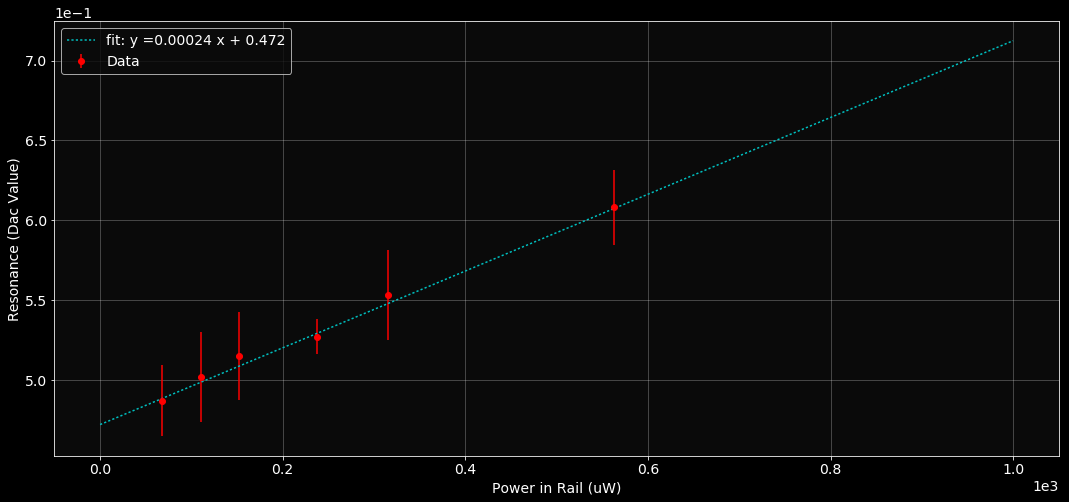

In [77]:
dacValue = [-0.01, -0.05, 0, 0.005, 0.01, -0.02]#, -0.03]
powerInRail = [238, 563, 151.6, 110.2, 67.7, 315]#, 396]
#resonantDac = [0.527, 0.608, 0.515, 0.502, 0.487, 0.553, 0.544]
resonantDac = [0.527, 0.608, 0.515, 0.502, 0.487, 0.553]#, 0.544]
resonanceErr = [0.011, 0.0236, 0.0276, 0.0281, 0.0222, 0.0283 ]#, ...]
fitVal, cov = fit(linear, powerInRail, resonantDac, sigma=arr(resonanceErr)/2)
xpts = np.linspace(0,1000, 3500)
fitData = linear(xpts, *fitVal)
errorbar(powerInRail, resonantDac, yerr=resonanceErr, marker='o', linestyle='', label='Data')
plot(xpts, fitData, ':', label='fit: y ='+str(round_sig(fitVal[0],3)) + ' x + '+str(round_sig(fitVal[1])))
legend()
xlabel('Power in Rail (uW)')
ylabel('Resonance (Dac Value)')
#errbar(powerInRail, resonantDac, 'o', yerr=resonanceerr)

Working backwards in the mathematica notebook

### some imports and definitions

In [296]:
from sympy.physics.wigner import wigner_6j
def SixJSymbol(a,b,c,d,e,f):
    return complex(wigner_6j(a,b,c,d,e,f))
from scipy.interpolate import interp1d 
def Interpolation(data):
    return interp1d(data[:,0],data[:,1],kind='cubic')

In [205]:
def transpose(l):
    # take transpose of list
    return list(map(list, zip(*l)))

### stuff..

Note that the reduced dipole matrix values are taken from:

Arora and Sahoo, Phys. Rev. A 86 033416 (2012)
   
And the level energies are taken from:

M Safronova and U Safronova, Phys. Rev. A 83 052508 (2011)

In [228]:
# e2 here is to convert from cm^-1 to m^1
ES12 = -33691e2;
keyS12 = [ ["Index", "Level", "Energy of Level (in m^-1)", "Reduced Dipole Matrix Element (e*a0)", "j"],
           [1, "5p_(1/2)", -21112e2, 4.227, 1/2],
           [2, "6p_(1/2)", -9976e2, 0.342, 1/2],
           [3, "7p_(1/2)", -5856e2, 0.118, 1/2],
           [4, "8p_(1/2)", -3856e2, 0.061, 1/2],
           [5, "9p_(1/2)", -2732e2, 0.046, 1/2],
           [6, "5p_(3/2)", -20874e2, 5.977, 3/2],
           [7, "6p_(3/2)", -9898e2, 0.553, 3/2],
           [8, "7p_(3/2)", -5821e2, 0.207, 3/2],
           [9, "8p_(3/2)", -3837e2, 0.114, 3/2],
           [10, "9p_(3/2)", -2721e2, 0.074, 3/2]];

def OmegaS12HigherLevels(level):
    return 2 * pi * c * (np.abs(transpose(keyS12)[2][level + 1] - ES12));
def dS12HigherLevels(level):
    return (el*a0)*transpose(keyS12)[3][level + 1];
def jS12HigherLevels(level): 
    return transpose(keyS12)[4][level + 1];

In [227]:
EP12 = -21112e2;

keyP12 = [["Index", "Level", "E of Level (in m^-1)", "Reduced Dipole Matrix Element (e*a0)", "j"],
          [1, "5s_(1/2)",  -33691e2, 4.227, 1/2],
          [2, "6s_(1/2)",  -13557e2, 4.144, 1/2],
          [3, "7s_(1/2)",  -7379e2,  0.962, 1/2],
          [4, "8s_(1/2)",  -4644e2,  0.507, 1/2],
          [5, "9s_(1/2)",  -3192e2,  0.333, 1/2],
          [6, "10s_(1/2)", -2321e2,  0.235, 1/2],
          [8, "4d_(3/2)",  -14335e2, 8.069, 3/2],
          [9, "5d_(3/2)",  -7990e2,  1.184, 3/2],
          [10, "6d_(3/2)", -5004e2,  1.002, 3/2],
          [11, "7d_(3/2)", -3411e2,  0.75,  3/2],
          [12, "8d_(3/2)", -2469e2,  0.58,  3/2],
          [13, "9d_(3/2)", -1869e2,  0.45,  3/2]];

def OmegaP12HigherLevels(level):
   return 2 * pi * c * (np.abs(transpose(keyP12)[2][level + 1] - EP12))

def dP12HigherLevels(level):
    return (el*a0)*transpose(keyP12)[3][level + 1]

def jP12HigherLevels(level):
    return transpose(keyP12)[4][level + 1]

In [226]:
transpose(keyP12)[4]

['j', 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]

In [222]:
jP12HigherLevels(1)

IndexError: list index out of range

### Some Numbers I need

In [254]:
intFromPow = (3415.031398)/(1.0763662990168073e-8)
Epsilon0 = 8.85418782e-12
LambdaTrap = 852e-9
# electron charge??
el = 1.60217657e-19;
# bohr radius
a0 = 0.529e-10;

#( 0 for Pi-polarized trapping light (E along quantization axis) *)
EpsilonTrap = 0; 

#this is the complex spherical tensor representation of the trap polarization at the atom, the first
# entry is the sigma plus polarization component, the second is the pi-polarized component, and 
# the third is the sigma minus polarization component.
uTrap = [0, 1, 0];


### data from before

In [137]:
powCal = [[0.600, 1.712],
   [0.610, 1.794],
   [0.620, 1.879],
   [0.630, 1.968],
   [0.640, 2.061],
   [0.650, 2.159],
   [0.660, 2.261],
   [0.670, 2.367],
   [0.68, 2.483],
   [0.69, 2.602],
   [0.70, 2.722],
   [0.75, 3.439],
   [0.80, 4.332],
   [0.825, 4.871],
   [0.850, 5.470],
   [0.845, 5.342],
   [0.875, 6.145],
   [0.900, 6.906],
   [0.95, 8.71],
   [0.975, 9.80],
   [1.00, 11.00],
   [1.05, 13.89],
   [1.10, 17.52],
   [1.15, 22.09],
   [1.20, 27.89],
   [1.25, 35.14],
   [1.3, 44.32],
   [1.35, 55.81],
   [1.40, 70.24],
   [1.47, 97.1],
   [1.5, 111.8],
   [1.6, 176.7],
   [1.7, 279.5],
   [1.8, 443.1],
   [1.9, 703.8],
   [2.00, 1119.],
   [2.05, 1414.],
   [2.10, 1790.],
   [2.15, 2263.],
   [2.20, 2865.],
   [2.25, 3626.],
   [2.275, 4086.],
   [2.300, 4600.],
   [2.325, 5187.],
   [2.350, 5837.],
   [2.360, 6121.],
   [2.375, 6575.],
   [2.390, 7070.],
   [2.395, 7240.],
   [2.400, 7430.],
   [2.405, 7610.],
   [2.410, 7790],
   [2.415, 7980.],
   [2.425, 8360.],
   [2.45, 9410.],
   [2.50, 11970],
   [2.55, 15220],
   [2.60, 19280],
   [2.65, 24500],
   [2.70, 31170],
   [2.73, 36030],
   [2.75, 39660]]


In [146]:
powCal = arr(powCal)
powCal[:,0]

array([ 0.6  ,  0.61 ,  0.62 ,  0.63 ,  0.64 ,  0.65 ,  0.66 ,  0.67 ,
        0.68 ,  0.69 ,  0.7  ,  0.75 ,  0.8  ,  0.825,  0.85 ,  0.845,
        0.875,  0.9  ,  0.95 ,  0.975,  1.   ,  1.05 ,  1.1  ,  1.15 ,
        1.2  ,  1.25 ,  1.3  ,  1.35 ,  1.4  ,  1.47 ,  1.5  ,  1.6  ,
        1.7  ,  1.8  ,  1.9  ,  2.   ,  2.05 ,  2.1  ,  2.15 ,  2.2  ,
        2.25 ,  2.275,  2.3  ,  2.325,  2.35 ,  2.36 ,  2.375,  2.39 ,
        2.395,  2.4  ,  2.405,  2.41 ,  2.415,  2.425,  2.45 ,  2.5  ,
        2.55 ,  2.6  ,  2.65 ,  2.7  ,  2.73 ,  2.75 ])

In [149]:
PowCalInt = Interpolation(powCal);

### Some Calibrations

In [118]:
def powOut(setP):
    return PowCalInt(volt(setP*10**3)) / 10**3

def PowCalInt(powCal):
    return Interpolation(powCal)

def freqCalInt(freqCal):
    return Interpolation(Sort(freqCal));

def volt(P):
    return 0.479262 + 0.215003 * np.log(P - 0.018189)

### defining the transition...

In [119]:
#(*Setting this to 3/2 calculates light shifts of the F=2 -> F'=3 transition*)
Je = 3/2

if Je == 1/2:
    def DeltaEtransition(I0, Fg, mFg, Fe, mFe):
        return DeltaEP12(Fe, mFe, I0) - DeltaES12(Fg, mFg, I0)
   
if Je == 3/2:
    def DeltaEtransition(I0, Fg, mFg, Fe, mFe):
        # ??? This was in brians code...
        print("Incorrect selection for J excited")
        return DeltaEP32(Fe, mFe, I0) - DeltaES12(Fg, mFg, I0);

### Some Atomic Physics

In [311]:
def DeltaES12(Fg, mFg, I0):
    first = -(1/4) * ((2 * I0)/(c * Epsilon0))
    print(first)
    second = AlphaScalarS12(Fg, mFg)
    print(second)
    third =  Ccoeff * AlphaVectorS12(Fg, mFg) * mFg / (2 * Fg)  
    print(third)
    fourth = - Dcoeff * AlphaTensorS12(Fg, mFg) * (3 *mFg**2 - Fg * (Fg + 1))/( 2 * Fg * (2 * Fg - 1)) 
    print(fourth)
    return first * (second + third + fourth)

def AlphaScalarS12(Fg, mFg): 
    return 1 / np.sqrt(3 * (2 * 1/2 + 1)) * AlphaReducedS12(0, (2 * pi * c) / LambdaTrap)

def AlphaReducedS12(Kappa, OmegaTrap):
    J = 1/2
    #GammaJpJ = 6.1*MHz
    GammaJpJ = 6.1e6
    
    const = (-1)**(J + Kappa + 1) * np.sqrt(2 * Kappa + 1)
    print('reduced const', const)
    sumTerm = 0
    for i in range(0, len(keyS12)-1):
        sumTerm += ((-1)**jS12HigherLevels(i) * SixJSymbol(1, Kappa, 1, J, jS12HigherLevels(i), J) 
                    * dS12HigherLevels(i)**2 * 1/hbar * np.real(1/(OmegaS12HigherLevels(i) - OmegaTrap - 
                    1j*GammaJpJ / 2) + (-1)**Kappa/(OmegaS12HigherLevels(i) + OmegaTrap + 1j*GammaJpJ/2)))
    return  const * sumTerm
            
def AlphaVectorS12(Fg, mFg):
    return ((-1)**(1/2 + 3/2 + Fg) * np.sqrt((2 * Fg * (2 * Fg + 1))/(Fg + 1)) * SixJSymbol(Fg, 1, Fg, 1/2, 3/2, 1/2)
            * AlphaReducedS12(1, (2 * pi * c)/LambdaTrap))

def AlphaTensorS12(Fg, mFg):
    return ((-1)**(1/2 + 3/2 + Fg + 1) * np.sqrt((2 * Fg * (2 * Fg - 1) * (2 * Fg + 1))/(3 * (Fg + 1) * (2 * Fg + 3))) 
        * SixJSymbol(Fg, 2, Fg, 1/2, 3/2, 1/2) * AlphaReducedS12(2, (2 * pi * c)/LambdaTrap))


### Final Functions

In [301]:
Ccoeff = np.conj(uTrap[2]) * uTrap[2] - np.conj(uTrap[0]) * uTrap[0];

Dcoeff = 1 - 3 * np.conj(uTrap[1]) * uTrap[1];

def depthFin(Pin):
    return trapDepth(intFromPow*(powOut(Pin)*1e-3)) # 1000 is for mw
    
def trapDepth(I0):
    # this gives the trap depth in mK
    # 1e-3 converts to mk
    return DeltaES12(2, 2, I0)/(k_B * 1e-3)

def CyclingShift(I0):
    DeltaEtransition(I0, 2, 2, 3, 3) / (2 * Pi * hbar * MHz)


### testing area

In [312]:
print(np.real(depthFin(7.15)))

-417345434932.0
reduced const (-1.8369701987210297e-16-1j)
(3.40812366817e-38-1.08994811711e-53j)
reduced const (5.302876193624535e-16+1.7320508075688772j)
0j
reduced const (-9.584377219623547e-16-2.23606797749979j)
0j
-1.0302148197244965


In [298]:
powOut(7.15)

In [291]:
term = intFromPow * powOut(7.15) * 1e-3
print(term)

2215619078.85


In [305]:
DeltaES12(2,2,term)

-417345434932.0
(2.08474258558e-38-7.65813235739e-54j)
0j
0j


(-8.7005780110121829e-27+3.1960865794579044e-42j)

In [295]:
sp.N(sp.I)

In [308]:
AlphaReducedS12(0, (2 * pi * c) / LambdaTrap)

reduced const (-1.8369701987210297e-16-1j)


(5.1065555797333622e-38-1.8758516658300697e-53j)